# OK, how do TMF measure up against test strips?

- white noise
- Isochronous motifs (done)
- Tempo modulated motifs (done)
- Intensity modulated motifs (done)
- Tempo and modulated motifs (done)


what qualifies this tmf
parametric sweeps

In [1]:
from starling_rhythm.utils.paths import PROCESSED_DIR, ensure_dir

In [2]:
PROCESSED_DIR

PosixPath('/mnt/cube/j8xing/starling_rhythm_mfdfa/data')

In [3]:
bID = 's_b1555_22'

In [4]:
motif_dir = PROCESSED_DIR / bID / 'motifs'

In [5]:
motifs = list(motif_dir.glob('*.wav'))

## Make Isochronous motifs

In [3]:
import numpy as np
from scipy.io.wavfile import read, write
from starling_rhythm.synth import taper_audio, float32_to_int16
import numpy as np
import pandas as pd

In [4]:
def intensity_ramper(intensity_kink, instances, baseline = 2/3):
    ## make acceleration logarithmic
    log_ramper = np.log(np.linspace(start = 1, stop = np.e, num = int(instances/2) + 1))
    print(log_ramper)
    
    ## flip to decelerate
    log_ramper = np.concatenate([log_ramper, np.flip(log_ramper)[1:]])
    print(log_ramper)
    
    ## generate isochronous baseline
    iso = np.full(len(log_ramper), np.mean(log_ramper))
    log_ramper = iso + intensity_kink * log_ramper
    print(log_ramper)
    
    ## normalize to sum 1
    ratios = log_ramper / sum(log_ramper)
    print(ratios)
    
    ## what should be the proper intensities?
    ### the sum of all intensities should be instances * baseline
    intensity_sum = instances * baseline
    print(intensity_sum)
    
    return ratios * intensity_sum

In [5]:
intensity_ramper(intensity_kink = 1, instances = 11)

[0.         0.29539453 0.52313716 0.70851307 0.86483973 1.        ]
[0.         0.29539453 0.52313716 0.70851307 0.86483973 1.
 0.86483973 0.70851307 0.52313716 0.29539453 0.        ]
[0.52579718 0.82119171 1.04893434 1.23431025 1.3906369  1.52579718
 1.3906369  1.23431025 1.04893434 0.82119171 0.52579718]
[0.04545455 0.07099105 0.09067914 0.10670466 0.12021892 0.13190337
 0.12021892 0.10670466 0.09067914 0.07099105 0.04545455]
7.333333333333333


array([0.33333333, 0.52060106, 0.66498033, 0.78250087, 0.8816054 ,
       0.96729134, 0.8816054 , 0.78250087, 0.66498033, 0.52060106,
       0.33333333])

In [9]:
np.mean(intensity_ramper(intensity_kink = 1, instances = 11))

0.6666666666666667

In [10]:
def output_gap_list(total_gap, kink_factor, gap_n):
    '''
    total_gap should be in samples
    kink_factor
    '''
    
    ## make acceleration logarithmic
    log_ramper = np.log(np.linspace(start = 1, stop = np.e, num = int(gap_n/2)))
    
    ## flip to decelerate
    log_ramper = np.concatenate([np.flip(log_ramper), log_ramper])
    
    ## generate isochronous baseline
    iso = np.full(len(log_ramper), np.mean(log_ramper))sum 
    log_ramper = iso + kink_factor * log_ramper
    
    ## normalize to sum 1
    ratios = log_ramper / sum(log_ramper)
    
    gap_list = (ratios * total_gap).astype(int)
    
    return np.concatenate([gap_list, [0]])

In [11]:
def motif_accelritar_stim(
    motif_address, 
    motif_n = 11, 
    total_gap = 3*48000, 
    kink_factor = 0, 
    ## intensity manipulation
    intensity_kink = 0,
    ## white noise?
    white_noise = False
):
    '''
    from a motif, output motif_accelritar_stim with a kink_factor
    return a dataframe with stimuli info
    '''
    
    rate, data = read(motif_address)
    
    if white_noise:
        data = np.random.random(size=len(data)) - 0.5
    
    motif_tile = np.tile(data, (motif_n, 1))
    
    intensity_modifier = intensity_ramper(intensity_kink = intensity_kink, instances = motif_n)
    
    gap_list = output_gap_list(total_gap, kink_factor, gap_n = motif_n)
    
    syn_song = []

    taper = 2*(rate/1000)
    
    for motif, intensity, gap in zip(motif_tile, intensity_modifier, gap_list):
        syn_song.append(intensity*taper_audio(motif, taper = int(taper)))
        syn_song.append(np.zeros(gap))

    syn_song = np.concatenate(syn_song)
    
    syn_song = syn_song / np.max(np.abs(data))
    syn_song = np.array(syn_song * 32767).astype("int16")
    
    ## save info
    motif_id = str(motif_address).split('/')[-1].split('.')[0]
    filename = motif_id + '_' + "kink" + str(kink_factor) + "_intensitykink" + str(intensity_kink) + "whiteNoise" + str(white_noise) + '.wav'
    directory = PROCESSED_DIR / 'TMF_ver'
    
    SAVE_PATH = directory / filename
    ensure_dir(SAVE_PATH)
    
    write(SAVE_PATH, rate, syn_song)
    
    info = pd.DataFrame(
        {
            'motif_address': [motif_address],
            'motif_id': [motif_id], 
            'motif_n': [motif_n],
            'total_gap': [total_gap],
            'kink_factor': [kink_factor],
            'kink_std': np.std(gap_list[:-1]),
            'intensity_kink': [intensity_kink],
            'intensity_kink_std': np.std(intensity_modifier),
            'white_noise': white_noise,
            'stimuli_path': [SAVE_PATH]
        }
    )
    
    return info

In [12]:
logs = []
for i, motif in zip(np.arange(0, len(motifs)), motifs):
    ## generate isochronous and tempo modulated
    for kink_factor in np.linspace(start = 0, stop = 1, num = 2):
        for intensity_kink in np.linspace(start = 0, stop = 1, num = 2):
            for white_noise in [True, False]:
                log_row = motif_accelritar_stim(
                    motif, kink_factor = kink_factor, intensity_kink = intensity_kink, white_noise = white_noise)
                log_row['id'] = i
                logs.append(log_row)

logs = pd.concat(logs)

In [13]:
logs

motif_address motif_id  motif_n  \
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
..                                                ...      ...      ...   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   

    total_gap  kink_factor     kink_std  intensity_kink  intensity_kink_std  \
0      144000          0.0     0.000000             0.0        1.110223e-16   
0      144000          0.0     0.000000             0.0        1.110223e-16   
0      144000          0.0     0.000000             1.0        2.076942e-01   
0      144000          0.0     0.000000             1.0        2.076942e-01   
0      144000          1.0  4532.303459             0.0        1.110223e-16   
..        ...          ...          ...             ...                 ...   
0      144000          0.0     0.000000             1.0        2.076942e-01   
0      144000          1.0  4532.303459             0.0        1.110223e-16   
0      144000          1.0  4532.303459             0.0        1.110223e-16   
0      144000          1.0  4532.303459             1.0        2.076942e-01   
0      144000          1.0  4532.303459             1.0        2.076942e-01   

    white_noise                                       stimuli_path  id  
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0  
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0  
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0  
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0  
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0  
..          ...                                                ...  ..  
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63  
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63  
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63  
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63  
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63  

[512 rows x 11 columns]

In [14]:
import IPython
import matplotlib.pyplot as plt

In [15]:
select_df = logs[
    logs['id'] == 1
]

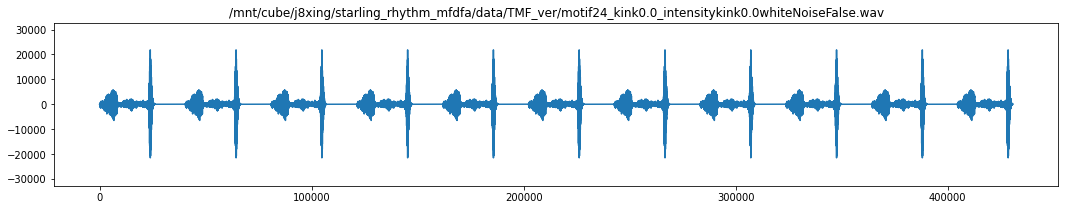

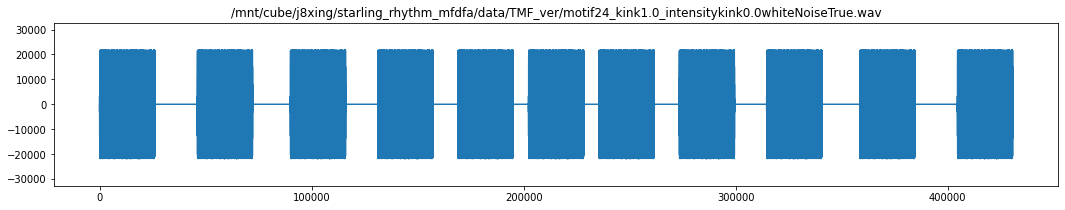

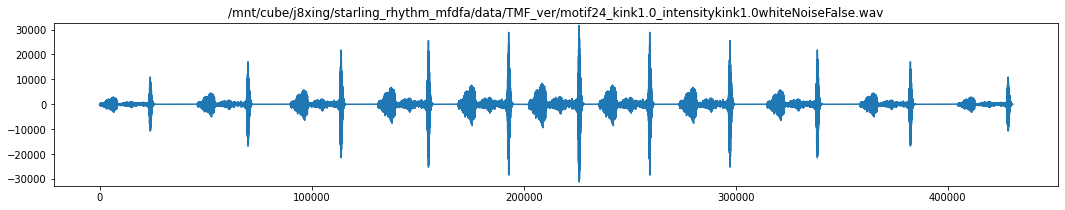

In [16]:
for stim in select_df['stimuli_path'].values:
    plt.figure(figsize = [18, 3])
    waveform = plt.plot(read(stim)[1])
    plt.title(str(stim))
    plt.ylim([-32767, 32767])
    IPython.display.display(IPython.display.Audio(str(stim)))

In [17]:
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm

/tmp/ipykernel_36206/123448108.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [18]:
from starling_rhythm.mfdfa import tmf
n_jobs = 36
verbose = 0

In [19]:
def tmf_n(
    address, 
    ns = 32, 
    amp_env_sr = 200,
    nt = 36
):
    SDoTMF = []
    for i in np.arange(0, nt):
        SDoTMF.append(tmf(address, ns = ns, amp_env_sr = amp_env_sr, hilbert_artifacts = True))
    
    return SDoTMF

In [20]:
%%time

with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    SDoTMF = parallel(
        delayed(tmf_n)(
            address,
            ns = 32,
            amp_env_sr = 200,
            nt = 1
        )
        for address in tqdm(logs.stimuli_path.values, desc = 'shuffle')
    )

shuffle:  70%|███████   | 360/512 [08:55<04:05,  1.62s/it]/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
shuffle: 100%|██████████| 512/512 [13:00<00:00,  1.52s/it]


CPU times: user 1.9 s, sys: 1.58 s, total: 3.48 s
Wall time: 14min 56s


In [21]:
logs['SDoTMF'] = SDoTMF

In [22]:
logs['mean_SDoTMF'] = np.mean(SDoTMF, axis = 1)

In [23]:
import seaborn as sns

In [24]:
logs

motif_address motif_id  motif_n  \
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif58       11   
..                                                ...      ...      ...   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   
0   /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  motif15       11   

    total_gap  kink_factor     kink_std  intensity_kink  intensity_kink_std  \
0      144000          0.0     0.000000             0.0        1.110223e-16   
0      144000          0.0     0.000000             0.0        1.110223e-16   
0      144000          0.0     0.000000             1.0        2.076942e-01   
0      144000          0.0     0.000000             1.0        2.076942e-01   
0      144000          1.0  4532.303459             0.0        1.110223e-16   
..        ...          ...          ...             ...                 ...   
0      144000          0.0     0.000000             1.0        2.076942e-01   
0      144000          1.0  4532.303459             0.0        1.110223e-16   
0      144000          1.0  4532.303459             0.0        1.110223e-16   
0      144000          1.0  4532.303459             1.0        2.076942e-01   
0      144000          1.0  4532.303459             1.0        2.076942e-01   

    white_noise                                       stimuli_path  id  \
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0   
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0   
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0   
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0   
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...   0   
..          ...                                                ...  ..   
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63   
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63   
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63   
0          True  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63   
0         False  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/TM...  63   

                  SDoTMF  mean_SDoTMF  
0    [38.18036783980517]    38.180368  
0   [15.523505112296613]    15.523505  
0    [66.80349904096376]    66.803499  
0   [12.555147686340405]    12.555148  
0   [116.98719308323054]   116.987193  
..                   ...          ...  
0   [22.936304814458907]    22.936305  
0    [51.32105908919123]    51.321059  
0   [26.720380624250204]    26.720381  
0    [77.84340457018399]    77.843405  
0   [32.539120981328665]    32.539121  

[512 rows x 13 columns]

In [25]:
sns.pointplot(
    data = logs[logs['white_noise'] == True].reset_index(), 
    x = 'kink_factor', 
    hue = 'intensity_kink', 
    y = 'mean_SDoTMF'
)

<AxesSubplot:xlabel='kink_factor', ylabel='mean_SDoTMF'>

Text(0, 0.5, 't_MF')

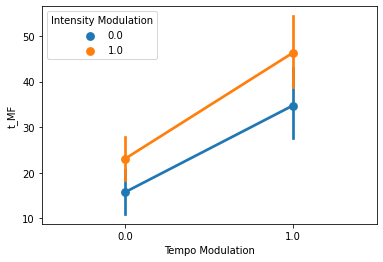

In [32]:
sns.pointplot(
    data = logs[logs['white_noise'] == False].reset_index(), 
    x = 'kink_factor', 
    hue = 'intensity_kink', 
    y = 'mean_SDoTMF'
)

plt.xlabel('Tempo Modulation')
plt.legend(title='Intensity Modulation')
plt.ylabel('t_MF')

## ANOVA

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('mean_SDoTMF ~ C(kink_factor) + C(intensity_kink) + C(kink_factor):C(intensity_kink)', data=logs[logs['white_noise'] == True].reset_index()).fit()
sm.stats.anova_lm(model, typ=2)

sum_sq     df           F  \
C(kink_factor)                    218249.260039    1.0  578.929331   
C(intensity_kink)                   4036.616252    1.0   10.707553   
C(kink_factor):C(intensity_kink)     165.213189    1.0    0.438246   
Residual                           95000.910509  252.0         NaN   

                                        PR(>F)  
C(kink_factor)                    3.089797e-67  
C(intensity_kink)                 1.216179e-03  
C(kink_factor):C(intensity_kink)  5.085754e-01  
Residual                                   NaN

In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('mean_SDoTMF ~ C(kink_factor) + C(intensity_kink) + C(kink_factor):C(intensity_kink)', data=logs[logs['white_noise'] == False].reset_index()).fit()
sm.stats.anova_lm(model, typ=2)

NameError: name 'logs' is not defined